# Classical ML Methods: Logistic Regression

## Packages and Presets

In [1]:
import pandas as pd
import numpy as np
import yaml
from icecream import ic
import os
import joblib

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)

from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns 

from imblearn.over_sampling import SMOTE

from tsfresh.transformers.per_column_imputer import PerColumnImputer
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%load_ext autoreload

import warnings
warnings.filterwarnings("ignore") # sanest python user

In [2]:
with open("classical_ml_config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Performance Without Feature Engineering

Preprocessing data: Since the data is already clean, we only need to split it into training and testing sets.

In [3]:
# Load data
train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

In [4]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]


X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [5]:
sm = SMOTE(random_state=config["general"]["seed"])
X_train, y_train = sm.fit_resample(X_train, y_train)
ic(X_train.shape, y_train.shape)
ic(np.unique(y_train, return_counts=True))

ic| X_train.shape: (16808, 187), y_train.shape: (16808,)
ic| np.unique(y_train, return_counts=True): (array([0., 1.]), array([8404, 8404]))


(array([0., 1.]), array([8404, 8404]))

Important: ElasticNet regularization requires scaled featrues.

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Instantiating and training a logistic regression model

In [7]:
# Train model
reg_no_feat_eng = LogisticRegressionCV(
    penalty = config["logistic_regression"]["penalty"],
    Cs = config["logistic_regression"]["Cs"],
    solver = config["logistic_regression"]["solver"],
    cv = config["logistic_regression"]["cv"],
    max_iter=config["logistic_regression"]["max_iter"],
    l1_ratios = np.linspace(0, 1, config["logistic_regression"]["num_l1_ratios"]),
    random_state = config["general"]["seed"],
    n_jobs = -1
)

reg_no_feat_eng.fit(X_train, y_train)

LogisticRegressionCV(cv=5,
                     l1_ratios=array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                     max_iter=1000, n_jobs=-1, penalty='elasticnet',
                     random_state=42, solver='saga')

In [8]:
joblib.dump(reg_no_feat_eng, config["paths"]["logistic_regression_no_feat_eng"])

['../weights/logistic_regression_no_feat_eng.pkl']

Finally, we predict the target variable and evaluate the model performance:

In [9]:
y_preds = reg_no_feat_eng.predict(X_test)
assert y_preds.shape == y_test.shape

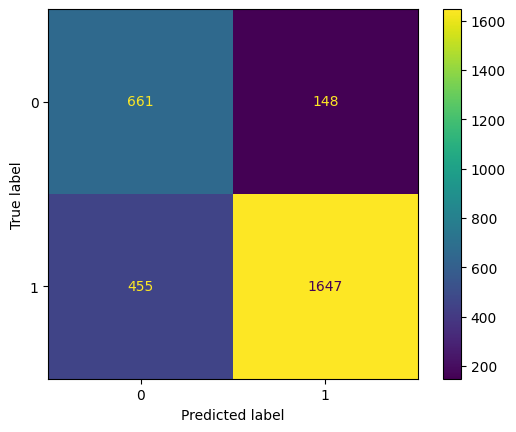

In [10]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [11]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.792855
Test balanced accuracy: 0.800299
Test f1 score: 0.845266
Test precision: 0.917549
Test recall: 0.783539


In [12]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.59      0.82      0.69       809
         1.0       0.92      0.78      0.85      2102

    accuracy                           0.79      2911
   macro avg       0.75      0.80      0.77      2911
weighted avg       0.83      0.79      0.80      2911



## Performance with Feature Engineering

In [13]:
# Load data
train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

In [14]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]


X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

First, RelevantFeatureAugmenter requires the column names to be strings. Thus, we first have to convert the column names to strings:

In [15]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [16]:
reg_feature_eng = LogisticRegressionCV(
    penalty = config["logistic_regression"]["penalty"],
    Cs = config["logistic_regression"]["Cs"],
    solver = config["logistic_regression"]["solver"],
    cv = config["logistic_regression"]["cv"],
    max_iter=config["logistic_regression"]["max_iter"],
    l1_ratios = np.linspace(0, 1, config["logistic_regression"]["num_l1_ratios"]),
    random_state = config["general"]["seed"],
    n_jobs = -1
)

In the following, we will use the `tsfresh` library (see [here](https://tsfresh.readthedocs.io/en/latest/)) to extract features from the time series data. We will then train a logistic regression model on the extracted features and evaluate the model performance. For using the `tsfresh` library, we first have to bring our data into the correct format:

In [17]:
def replace_padded_zeros(row):
    row_list = row.tolist()
    # We want to go from the right, so we reverse the list:
    reversed_list = row_list[::-1]
    count0s=0
    for i in range(len(reversed_list)):
        if reversed_list[i] != 0:
            break
        reversed_list[i] = np.nan
        count0s+=1
        
    # Reverse the list again before returning
    return reversed_list[::-1]


In [18]:
# melt the training dataframe
X_train_copy = X_train.copy(deep=True)
X_train_copy = X_train_copy.apply(lambda row: pd.Series(replace_padded_zeros(row)), axis=1)
X_train_copy["id"] = X_train_copy.index
X_train_melted =(
    X_train_copy
    .melt(id_vars="id", var_name="time", value_name="value")
    .sort_values(by=["id", "time"])
)
# get rid of padding to not ruin the engineered features
X_train_melted = X_train_melted.dropna()

# melt the test dataframe
X_test_copy = X_test.copy(deep=True) 
X_test_copy = X_test_copy.apply(lambda row: pd.Series(replace_padded_zeros(row)), axis=1)
X_test_copy["id"] = X_test_copy.index

X_test_melted =(
    X_test_copy
    .melt(id_vars="id", var_name="time", value_name="value")
    .sort_values(by=["id", "time"])
)
# get rid of padding to not ruin the engineered features
X_test_melted = X_test_melted.dropna()

In [19]:
# We will follow this tutorial:
# https://towardsdatascience.com/expanding-your-regression-repertoire-with-regularisation-903d2c9f7b28
# and will use the EfficientFCParameters function for feature extraction
X_train_augmented = extract_features(
    X_train_melted,
    column_id="id",
    column_sort="time",
    column_value="value",
    default_fc_parameters=EfficientFCParameters(),
)  
X_test_augmented = extract_features(
    X_test_melted,
    column_id="id",
    column_sort="time",
    column_value="value",
    default_fc_parameters=EfficientFCParameters(),
)  

Feature Extraction: 100%|██████████| 79/79 [00:07<00:00, 10.64it/s]


In [20]:
X_train_merged = pd.merge(
    X_train, X_train_augmented, left_index=True, right_index=True
)
X_test_merged = pd.merge(
    X_test, X_test_augmented, left_index=True, right_index=True
)

# assert that no rows were lost
assert X_train_merged.shape[0] == X_train.shape[0]
assert X_test_merged.shape[0] == X_test.shape[0]
assert X_train_merged.index.equals(X_train.index)
assert X_test_merged.index.equals(X_test.index)

In [21]:
imputer = PerColumnImputer()
X_train_merged = imputer.fit_transform(X_train_merged)
X_test_merged = imputer.transform(X_test_merged)

# convert column names to string
X_train_merged.columns = X_train_merged.columns.astype(str)
X_test_merged.columns = X_test_merged.columns.astype(str)

In [22]:
sm = SMOTE(random_state=config["general"]["seed"])
X_train_merged, y_train = sm.fit_resample(X_train_merged, y_train)
ic(X_train_merged.shape, y_train.shape)
ic(np.unique(y_train, return_counts=True))

ic| X_train_merged.shape: (16808, 964), y_train.shape: (16808,)
ic| np.unique(y_train, return_counts=True): (array([0., 1.]), array([8404, 8404]))


(array([0., 1.]), array([8404, 8404]))

Next, we create a Pipeline to standardize and one-hot encode the data. This is necessary since some of the newly created features are categorical or do not lie within the same range as the original features. Note that for logistic regression, we will also have to standardize the one-hot encoded features.

Finally, we train a logistic regression model on the extracted features and evaluate the model performance:

In [23]:
# extract categorical columns from the newly engineered features
cat_cols = X_train_merged.iloc[:, 187:].loc[:, X_train_merged.iloc[:, 187:].nunique() < 5].columns
# extract numerical columns from the newly engineered features and original features
numeric_cols = [col for col in X_train_merged.columns if col not in cat_cols]

# preprocessing pipeline for numerical features
num_trans = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# preprocessing pipeline for categorical features
cat_trans = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown="ignore")),
    ("scaler", StandardScaler(with_mean=False)) # standardize the one-hot encoded features
])


preprocessor = ColumnTransformer(transformers=[
    ("num", num_trans, numeric_cols),
    ("cat", cat_trans, cat_cols)
])

X_train_preprocessed = preprocessor.fit_transform(X_train_merged)
X_test_preprocessed = preprocessor.transform(X_test_merged)

In [24]:
reg_feature_eng.fit(X_train_preprocessed, y_train)

LogisticRegressionCV(cv=5,
                     l1_ratios=array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                     max_iter=1000, n_jobs=-1, penalty='elasticnet',
                     random_state=42, solver='saga')

In [25]:
joblib.dump(reg_feature_eng, config["paths"]["logistic_regression_feat_eng"])

['../weights/logistic_regression_feat_eng.pkl']

In [26]:
y_preds = reg_feature_eng.predict(X_test_preprocessed)

assert y_preds.shape == y_test.shape

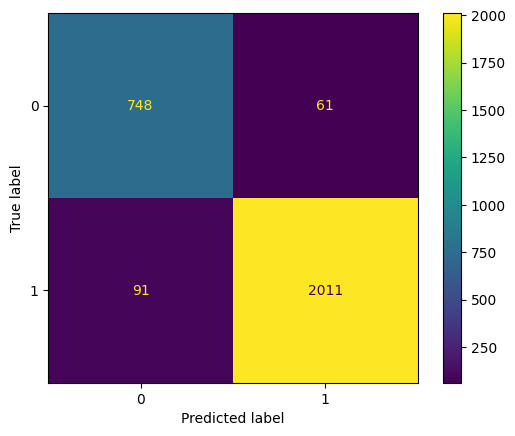

In [27]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [28]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.947784
Test balanced accuracy: 0.940653
Test f1 score: 0.963584
Test precision: 0.970560
Test recall: 0.956708


In [29]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91       809
         1.0       0.97      0.96      0.96      2102

    accuracy                           0.95      2911
   macro avg       0.93      0.94      0.94      2911
weighted avg       0.95      0.95      0.95      2911

